# XID+PACS GAMA-09 Prior

In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table , join
from mocpy import MOC
from astropy.io import fits
from astropy import wcs

/cm/shared/apps/python/intel/intelpython3/3.5.3/envs/jupyterhub/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
import seaborn as sns

This notebook uses all the raw data from the XID+PACS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources.

In [4]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_GAMA-09/data/holes_GAMA-09_ukidss_k_O16_20180417.fits')

filename='../../dmu18/dmu18_HELP-PACS-maps/data/GAMA-09_PACS100_v0.9.fits'
hdulist = fits.open(filename)
im100phdu=hdulist['IMAGE'].header
gama09_moc=MOC.from_image(im100phdu,13, ~np.isnan(hdulist['IMAGE'].data))
gama09_moc.write('./data/gama09_moc.fits')



im_moc=pymoc.MOC()
im_moc.read('./data/gama09_moc.fits')

Final=Sel_func.intersection(im_moc)


In [5]:
#Final.write('./data/testMoc.fits', overwrite=True)
#Final=pymoc.MOC()
#Final.read('./data/testMoc.fits')


## Read in CIGALE predictions catalogue

In [6]:
cigale=Table.read('../../dmu28/dmu28_GAMA-09/data/GAMA9_Ldust_prediction_results.fits')


In [5]:
cigale['id'].name = 'help_id'

In [6]:
cigale

help_id,bayes.dust.luminosity,bayes.dust.luminosity_err,best.omegacam_u,best.megacam_u,best.omegacam_g,best.suprime_g,best.decam_g,best.megacam_g,best.gpc1_g,best.suprime_r,best.gpc1_r,best.megacam_r,best.omegacam_r,best.decam_r,best.gpc1_i,best.megacam_i,best.omegacam_i,best.suprime_i,best.gpc1_z,best.vista_z,best.megacam_z,best.suprime_z,best.decam_z,best.gpc1_y,best.suprime_y,best.vista_y,best.ukidss_y,best.ukidss_j,best.vista_j,best.ukidss_h,best.vista_h,best.vista_ks,best.ukidss_k
,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J082912.113+014254.016,1.7756811583627856e+39,1.8560994213383705e+39,0.0006849655648856183,0.0008213525215570016,0.0014418320784829225,0.0014851635254180297,0.0014918097398899804,0.0015248420785701489,0.0015223639970083685,0.0029236244063870925,0.0029323451806340392,0.0029942044550754767,0.003071945806420398,0.003209946563396643,0.00570727344151689,0.005874273794688017,0.006124423478050316,0.006517263751715815,0.012043668064701779,0.012387236998768944,0.012730939515909855,0.012885496989621615,0.013894760724993507,0.015677503791890205,0.015995150517214757,0.01681551604212792,0.017040868125072547,0.024214296725186508,0.02429380670766754,0.03624442746030166,0.03653520866519151,0.053322189508958964,0.05449461857253117
HELP_J082913.120+014309.267,2.7021265703371776e+37,2.4317979538966422e+36,0.05731104329672883,0.056223578961906474,0.06033796980008266,0.06082318037150582,0.06095714255843882,0.060962559918838935,0.06123168837954967,0.05832850068459655,0.05801617455383524,0.0574112860668829,0.05741336122906761,0.056988475834606624,0.05282675100407725,0.053128606958725344,0.05306034143787001,0.05267269867326263,0.051136801552879335,0.051096163964210975,0.051204577645507635,0.05120398359763581,0.05122226385822606,0.05100542972748624,0.05089417995814178,0.051669357982216245,0.052035689812129096,0.053585319826126916,0.05354605081471752,0.05234953875464276,0.052339845325697625,0.052655239140812916,0.0514389634370146
HELP_J082913.510+014205.882,4.570194861817776e+37,2.8856447896428874e+37,0.001562775024576193,0.0019241849445430818,0.004073465839980223,0.004389458937042463,0.004445338813423105,0.0046145338160607985,0.004617749979019916,0.013338348306415565,0.013418082449615516,0.013756858071279767,0.014021819449388108,0.01455585883157852,0.021016747199825565,0.02094968585405312,0.02126166115867816,0.021866551844849095,0.027435222606925637,0.02793834579131693,0.02841994636277121,0.02873496116158678,0.030069647897269628,0.032687682671318524,0.03361467379577717,0.03654262073705172,0.03715744099421227,0.05233128843384468,0.0525172784307798,0.06935969566164578,0.06970494617425149,0.09128148854208384,0.09383798173773936
HELP_J082913.660+014249.800,1.5495572578977246e+39,2.0426412306543896e+39,0.0007113458085920682,0.0008620998241307844,0.0014636804186210113,0.0015183653964489588,0.001528907940829464,0.0015650614718851665,0.001565504843687772,0.003486666574064081,0.0034925073419556116,0.003569124910119692,0.003707632994832172,0.003974755257606487,0.009555373494452808,0.009514978147316,0.009834455087319656,0.01053562651452195,0.017090714828527045,0.01772392654238113,0.017995607058220953,0.018406453207120137,0.01938260611424127,0.021299714542906932,0.022002392212932025,0.024543109914095355,0.025282734427615784,0.03732825099814391,0.037421056282661354,0.061449745967043015,0.06211407956664785,0.08968285075940517,0.09202998934088379
HELP_J082914.042+014215.484,1.9836831174912827e+39,1.1247053696095027e+38,6.298024535939316,6.138427217228513,6.478874044154541,6.499129387376567,6.5054687822726445,6.517273282028814,6.524689489260027,5.877294815665693,5.8475216229471565,5.792011

## Read in photoz

In [7]:
photoz=Table.read('../../dmu24/dmu24_GAMA-09/data/master_catalogue_gama-09_20171206_photoz_20180213_r_optimised.fits')

In [8]:
photoz

help_id,RA,DEC,id,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,za_hb,chi_r_eazy,chi_r_atlas,chi_r_cosmos,chi_r_stellar,stellar_type
bytes27,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6
HELP_J084930.013-020417.068,132.37505356730503,-2.07140772342553,30302,0.821,0.3029,1.3791,0.798,-99.0,-99.0,-99.0,-99.0,0.7474615125223136,-99.0,-99.0,-99.0,-99.0,
HELP_J085343.238-011847.076,133.430156467305,-1.3130766064255301,30303,1.1554,0.3875,1.9962,0.797,-99.0,-99.0,-99.0,-99.0,1.017680534872741,-99.0,-99.0,-99.0,-99.0,
HELP_J084950.135-013553.799,132.45889656730503,-1.5982775844255301,30304,1.0387,0.3587,1.78,0.8,-99.0,-99.0,-99.0,-99.0,0.9290274556241438,-99.0,-99.0,-99.0,-99.0,
HELP_J090051.096-013904.046,135.21289956730502,-1.65112388142553,30306,1.0914,0.3751,1.8732,0.796,-99.0,-99.0,-99.0,-99.0,0.9699034467909559,-99.0,-99.0,-99.0,-99.0,
HELP_J085606.834-010133.117,134.02847336730503,-1.02586584842553,30307,1.0371,0.3628,1.7717,0.796,-99.0,-99.0,-99.0,-99.0,0.9232576825764145,-99.0,-99.0,-99.0,-99.0,
HELP_J090529.562-011041.306,136.373173467305,-1.17814049642553,30308,1.1091,0.3792,1.9078,0.797,-99.0,-99.0,-99.0,-99.0,0.9817405966027227,-99.0,-99.0,-99.0,-99.0,
HELP_J090046.918-011856.173,135.19549056730503,-1.3156034864255302,30312,0.9841,0.3466,1.6739,0.796,-99.0,-99.0,-99.0,-99.0,0.8833496027298801,-99.0,-99.0,-99.0,-99.0,
HELP_J085032.410-011540.279,132.63504356730502,-1.26118848342553,30313,1.109,0.3792,1.9078,0.797,-99.0,-99.0,-99.0,-99.0,0.9817405966027227,-99.0,-99.0,-99.0,-99.0,
HELP_J085443.327-011651.769,133.68052766730503,-1.28104686042553,30314,0.9931,0.3506,1.6899,0.796,-99.0,-99.0,-99.0,-99.0,0.8889996515380697,-99.0,-99.0,-99.0,-99.0,


## Join CIGALE and photoz tables

In [9]:
prior=join(cigale,photoz,keys='help_id')

In [10]:
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
f_pred=prior['bayes.dust.luminosity']/(4*np.pi*cosmo.luminosity_distance(prior['z1_median']).to(u.cm))


In [11]:
prior=prior[np.isfinite(f_pred.value)][np.log10(f_pred.value[np.isfinite(f_pred.value)])>8.5]

In [12]:
prior['DEC'].name='Dec'

## Read in Maps

In [13]:
im100fits='../../dmu18/dmu18_HELP-PACS-maps/data/GAMA-09_PACS100_v0.9.fits'
im160fits='../../dmu18/dmu18_HELP-PACS-maps/data/GAMA-09_PACS160_v0.9.fits'
#output folder
output_folder='./'

In [14]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im100hdu=hdulist['IMAGE'].header

w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im160hdu=hdulist['IMAGE'].header

w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist.close()

## Read in PSF

In [15]:
pacs100_psf=fits.open('../../dmu18/dmu18_GAMA-09/dmu18_PACS_100_PSF_GAMA09_20190131.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_GAMA-09/dmu18_PACS_160_PSF_GAMA09_20190131.fits')

centre100=np.long((pacs100_psf[0].header['NAXIS1']-1)/2)
radius100=10
centre160=np.long((pacs160_psf[0].header['NAXIS1']-1)/2)
radius160=10

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[0].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[0].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map

In [16]:
print(pind100)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


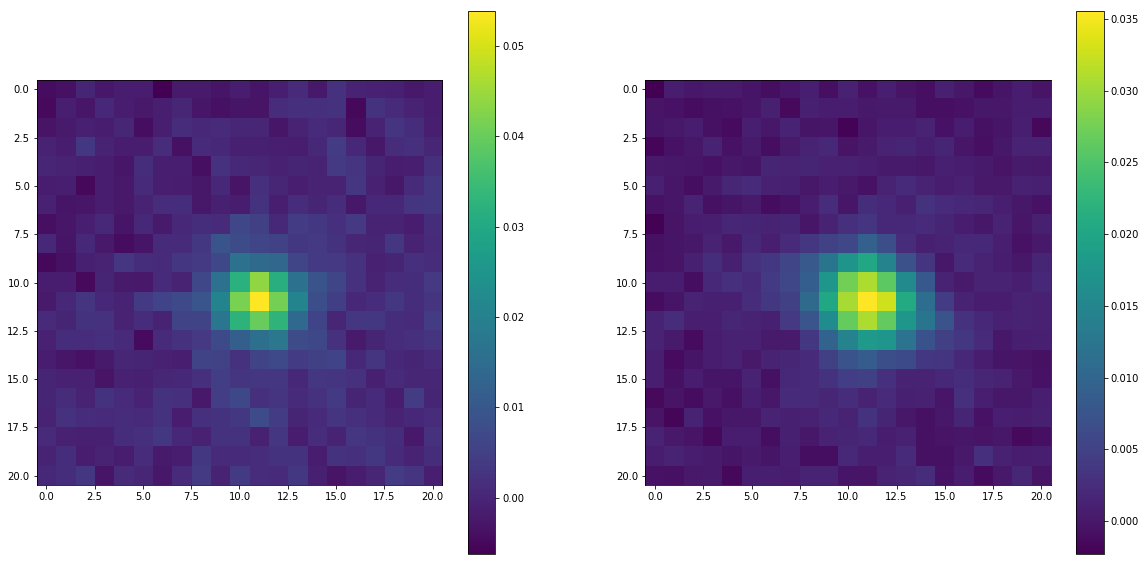

In [17]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[0].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()

## Set XID+ prior class

In [18]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Sel_func)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(prior['RA'] ,prior['Dec'] ,'GAMA09_Ldust_prediction_results.fits',ID=prior['help_id'])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Sel_func)
prior160.prior_cat(prior['RA'] ,prior['Dec'] ,'GAMA09_Ldust_prediction_results.fits',ID=prior['help_id'])
prior160.prior_bkg(0.0,5)

KeyboardInterrupt: 

In [16]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[0].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [17]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
xidplus.io.pickle_dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},'Master_prior.pkl')
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 2165 tiles required for input catalogue and 18 large tiles
writing total_bytes=781068219...
writing bytes [0, 781068219)... done.


SystemExit: 

In [18]:
ls -ltrh

total 1525656
drwxr-xr-x@ 3 pdh21  pdh21   102B 14 Feb 16:33 data/
-rw-rw-r--  1 pdh21  pdh21    41K 15 Feb 11:16 XID+PACS_prior.ipynb
-rw-rw-r--  1 pdh21  pdh21    18K 15 Feb 11:25 Tiles.pkl
-rw-rw-r--  1 pdh21  pdh21   745M 15 Feb 11:25 Master_prior.pkl
